In [1]:
library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)


load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/QC_output/"

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Attaching SeuratObject

Loading required package: Rcpp

ℹ Loading Socrates

Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map,

In [2]:
rep_1 <- here(data_path,"zea_mays.sciATAC_rep1_QC_soc_obj.rds")
rep_2 <- here(data_path,"zea_mays.sciATAC_rep2_QC_soc_obj.rds")
prefix <- "Zm_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj




[1] "Merging Object"
[1] "Generating Socrates Obj"


In [3]:
    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)

[1] "Generating Graphs"


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"3 x values <= 0 omitted from logarithmic plot"


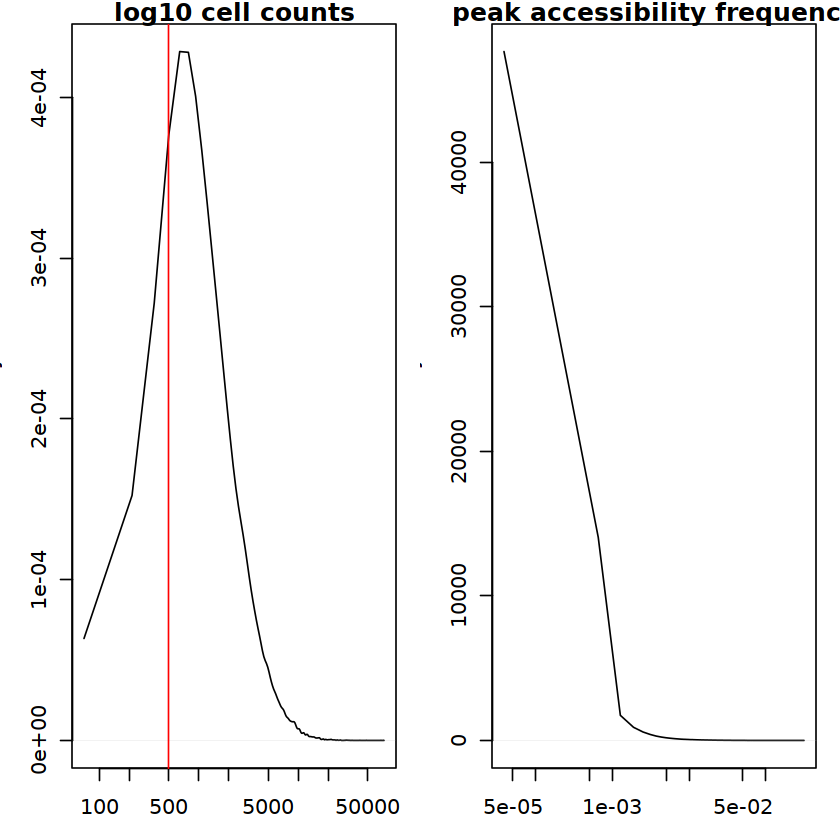

In [4]:
layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")

In [5]:
head(soc.obj$counts)

   [[ suppressing 34 column names 'BC:Z:GTGAAAGATCAGAGCGAGTGGCCACTAA-Zm_rep1_P4_10x.rep1', 'BC:Z:GTGGCCTAGCTTAGCGAATTCCTACTAA-Zm_rep1_P5_10x.rep1', 'BC:Z:CGTACGCTTGTACTAAGGGTAGCAACAT-Zm_rep1_P7_10x.rep1' ... ]]



6 x 17959 sparse Matrix of class "dgCMatrix"
                                                                              
chr1_10000001_10000500   . . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1_1000001_1000500     . . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1_100001_100500       . . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1_100001001_100001500 1 . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1_100001501_100002000 1 . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1_100002001_100002500 . . . . . . . . . . . . . . . . . . . . . . . . . . .
                                             
chr1_10000001_10000500   . . . . . . . ......
chr1_1000001_1000500     . . . . . . . ......
chr1_100001_100500       . . . . . . . ......
chr1_100001001_100001500 . . . . . . . ......
chr1_100001501_100002000 . . . . . . . ......
chr1_100002001_100002500 . . . . . . . ......

 .....suppressing 17925 columns in show(); maybe adjust 'options(max.print= *, 

ℹ Rendering development documentation for "projectUMAP"



In [8]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=cell.counts.threshold,  # minimum number of accessible features per cell
                     min.t=0.001,  # minimum feature frequency across cells
                     max.t=0.1, # maximum feature frequency across cells
                     verbose=T)


# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)

   * Input: cells = 17742 | peaks = 77923

   * Filtered: cells = 17553 | peaks = 70125



In [7]:
soc.obj$acr 

List of 4
 $ meta       :'data.frame':	17742 obs. of  8 variables:
  ..$ cellID     : chr [1:17742] "BC:Z:GTGAAAGATCAGAGCGAGTGGCCACTAA-Zm_rep1_P4_10x.rep1" "BC:Z:GTGGCCTAGCTTAGCGAATTCCTACTAA-Zm_rep1_P5_10x.rep1" "BC:Z:CGTACGCTTGTACTAAGGGTAGCAACAT-Zm_rep1_P7_10x.rep1" "BC:Z:GTTTCGCCGTCCAGCGAGTTTCGACTAA-Zm_rep1_P6_10x.rep1" ...
  ..$ total      : num [1:17742] 130500 79068 66736 55804 53708 ...
  ..$ tss        : num [1:17742] 30598 27529 27423 19968 17311 ...
  ..$ acrs       : num [1:17742] 43932 40483 46597 31883 26815 ...
  ..$ ptmt       : num [1:17742] NA NA NA NA NA NA NA NA NA NA ...
  ..$ nSites     : num [1:17742] 72161 41701 33010 29000 30014 ...
  ..$ log10nSites: num [1:17742] 4.86 4.62 4.52 4.46 4.48 ...
  ..$ sampleID   : chr [1:17742] "rep1" "rep1" "rep1" "rep1" ...
 $ counts     :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:19808093] 0 7 12 15 16 19 35 52 65 72 ...
  .. ..@ p       : int [1:17743] 0 14803 28261 42940 53972 63387 7701

In [11]:
# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="SVD", 
                      n.pcs=30, 
                      num.var=35000,
                      svd_slotName="SVD")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=100,
                       m.dist=0.1,
                       svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

09:21:21 UMAP embedding parameters a = 1.577 b = 0.8951

09:21:21 Read 17553 rows and found 29 numeric columns

09:21:21 Using Annoy for neighbor search, n_neighbors = 100

09:21:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:21:23 Writing NN index file to temp file /tmp/RtmptCE5os/file3e426242d18f0

09:21:23 Searching Annoy index using 16 threads, search_k = 10000

09:21:25 Annoy recall = 100%

09:21:28 Commencing smooth kNN distance calibration using 16 threads

09:21:32 Initializing from normalized Laplacian + noise

09:21:33 Commencing optimization for 200 epochs, with 2620550 positive edges

09:22:05 Optimization finished



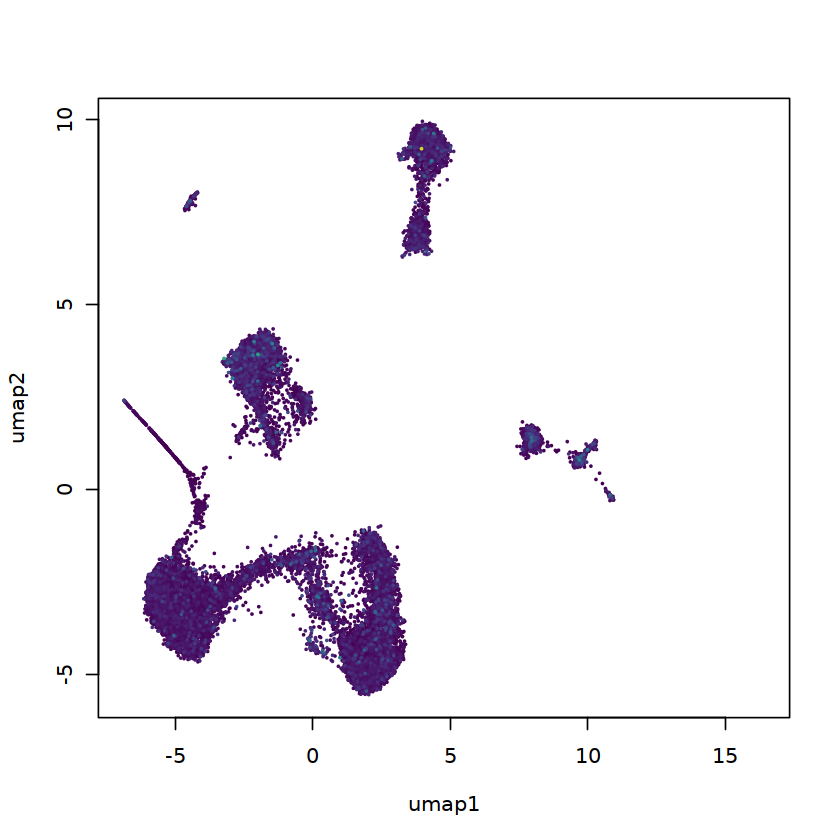

In [12]:
plotUMAP(soc.obj.project_umap, cex=0.3, column = "total")

In [13]:
tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "SVD", svd_slotName="SVD")

 - Creating synthetic doublets ...

 - Created 85000 synthetic doublets ...

 - Creating original projection ...

 - Merging synthetic and original cells ...

 - Projecting to UMAP ...

 - Computing KNN doublets (SVD)...

 - Computing KNN doublets (UMAP)...



In [14]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=F, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

 - libraryVar: sampleID



In [15]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
prcnt_to_remove

[1] 2.666365

In [16]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
calculated_value <- (100 - prcnt_to_remove)/100
remove_val_greater <- sort(tfidf.obj.dob.filt$meta$doubletscore)[calculated_value*length(tfidf.obj.dob.filt$meta$doubletscore)]

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ readr::col_factor() masks Socrates::col_factor(), scales::col_factor()
✖ dplyr::collapse()   masks IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()      masks matrixStats::count()
✖ dplyr::desc()       masks IRanges::desc()
✖ purrr::discard()    masks Socrates::discard(), scales::discard()
✖ tidyr::expand()     masks Socrates::expand(), S4Vectors::expand(), Matrix::expand()
✖ tidyr::fill()       masks VGAM::fill()
✖ dpl

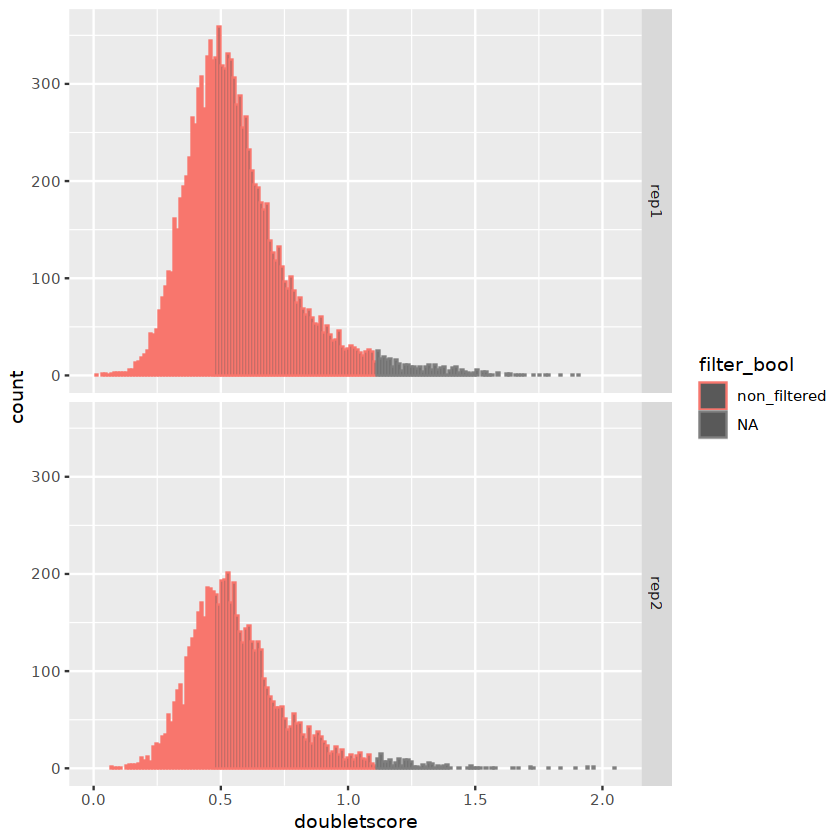

In [17]:
library(tidyverse)
as_tibble(tfidf.obj.dob.filt$meta) %>% 
    mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
             doubletscore < remove_val_greater ~ "filtered"))  %>% 
    ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)

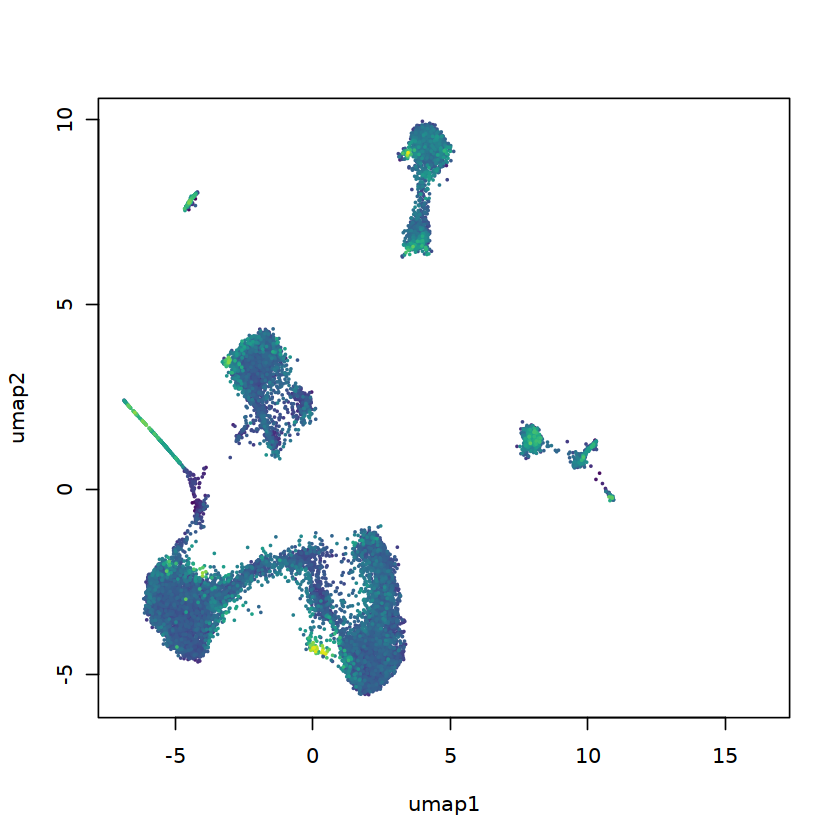

In [18]:
plotUMAP(tfidf.obj.dob.filt, cex=0.3, column = "doubletscore")

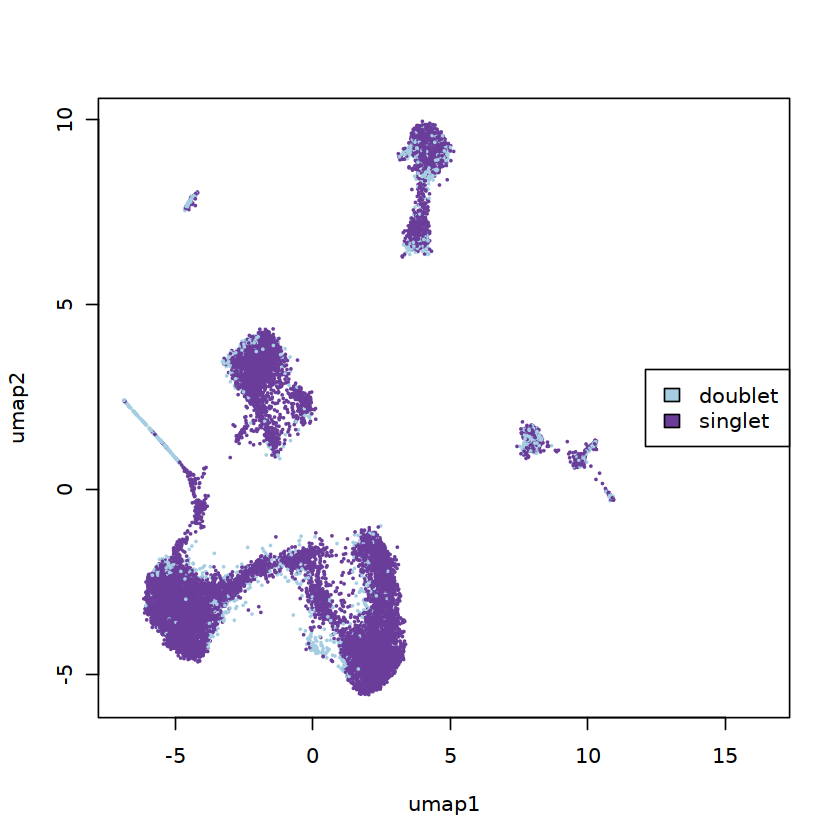

In [19]:
plotUMAP(tfidf.obj.dob.filt, cex=0.3, column = "d.type")

In [20]:
remove_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered"))  %>% 
        ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)
    
    new_meta <- subset(old_meta, doubletscore < calculated_value) 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    new_meta$d.type <- "singlet"
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

plot_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered")) 

    
    return(grabbed_graph)

}

In [21]:
tfidf.obj.dob.filt.removed.graph <- plot_top_x_doublet_percent(tfidf.obj.dob.filt)
head(tfidf.obj.dob.filt.removed.graph)

cellID,total,tss,acrs,ptmt,nSites,log10nSites,sampleID,umap1,umap2,doubletscore,d.type,filter_bool
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
BC:Z:GTGAAAGATCAGAGCGAGTGGCCACTAA-Zm_rep1_P4_10x.rep1,130500,30598,43932,NA,72161,4.858303,rep1,-1.987459,3.201222,0.3882353,singlet,non_filtered
BC:Z:GTGGCCTAGCTTAGCGAATTCCTACTAA-Zm_rep1_P5_10x.rep1,79068,27529,40483,NA,41701,4.620146,rep1,-3.233499,3.540243,0.3764706,singlet,non_filtered
BC:Z:CGTACGCTTGTACTAAGGGTAGCAACAT-Zm_rep1_P7_10x.rep1,66736,27423,46597,NA,33010,4.518646,rep1,-1.273583,3.350637,0.4352941,singlet,non_filtered
BC:Z:GTTTCGCCGTCCAGCGAGTTTCGACTAA-Zm_rep1_P6_10x.rep1,55804,19968,31883,NA,29000,4.462398,rep1,-1.474879,3.936237,0.4235294,singlet,non_filtered
BC:Z:CGTACGAGTCAAAAACAGTGGCCACTAA-Zm_rep1_P7_10x.rep1,53708,17311,26815,NA,30014,4.477324,rep1,4.319132,8.884287,0.6705882,singlet,non_filtered
BC:Z:GTCCGCGGCTACAGCGAGAGTGGACCGG-Zm_rep1_P3_10x.rep1,51297,24619,42278,NA,24360,4.386677,rep1,-1.180167,3.419619,0.2117647,singlet,non_filtered


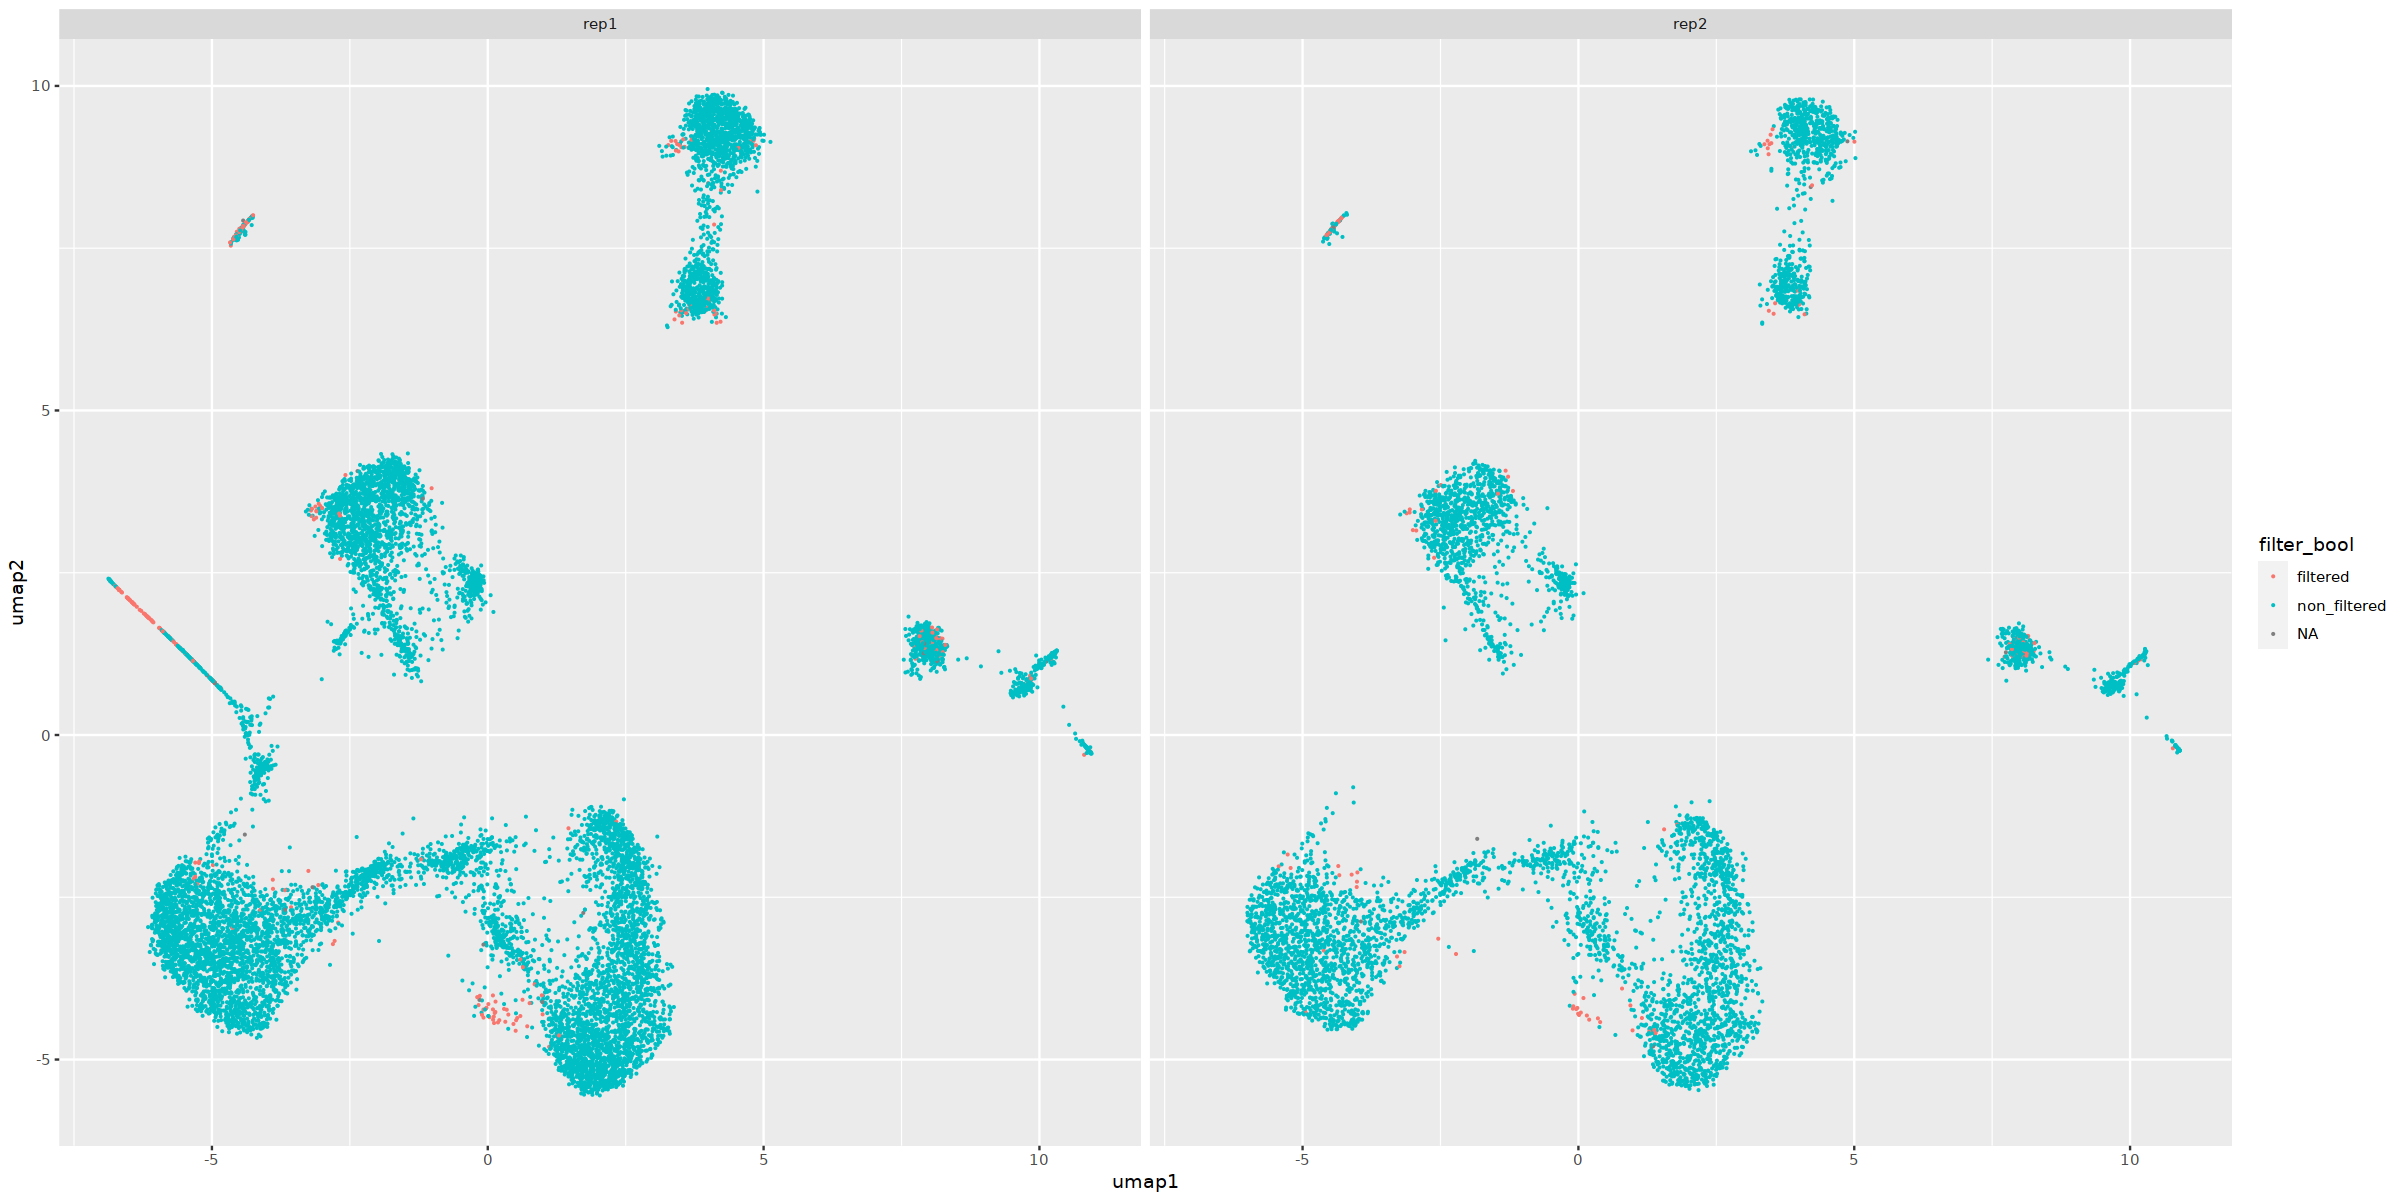

In [22]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(tfidf.obj.dob.filt.removed.graph ,aes(umap1, umap2, color = filter_bool)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

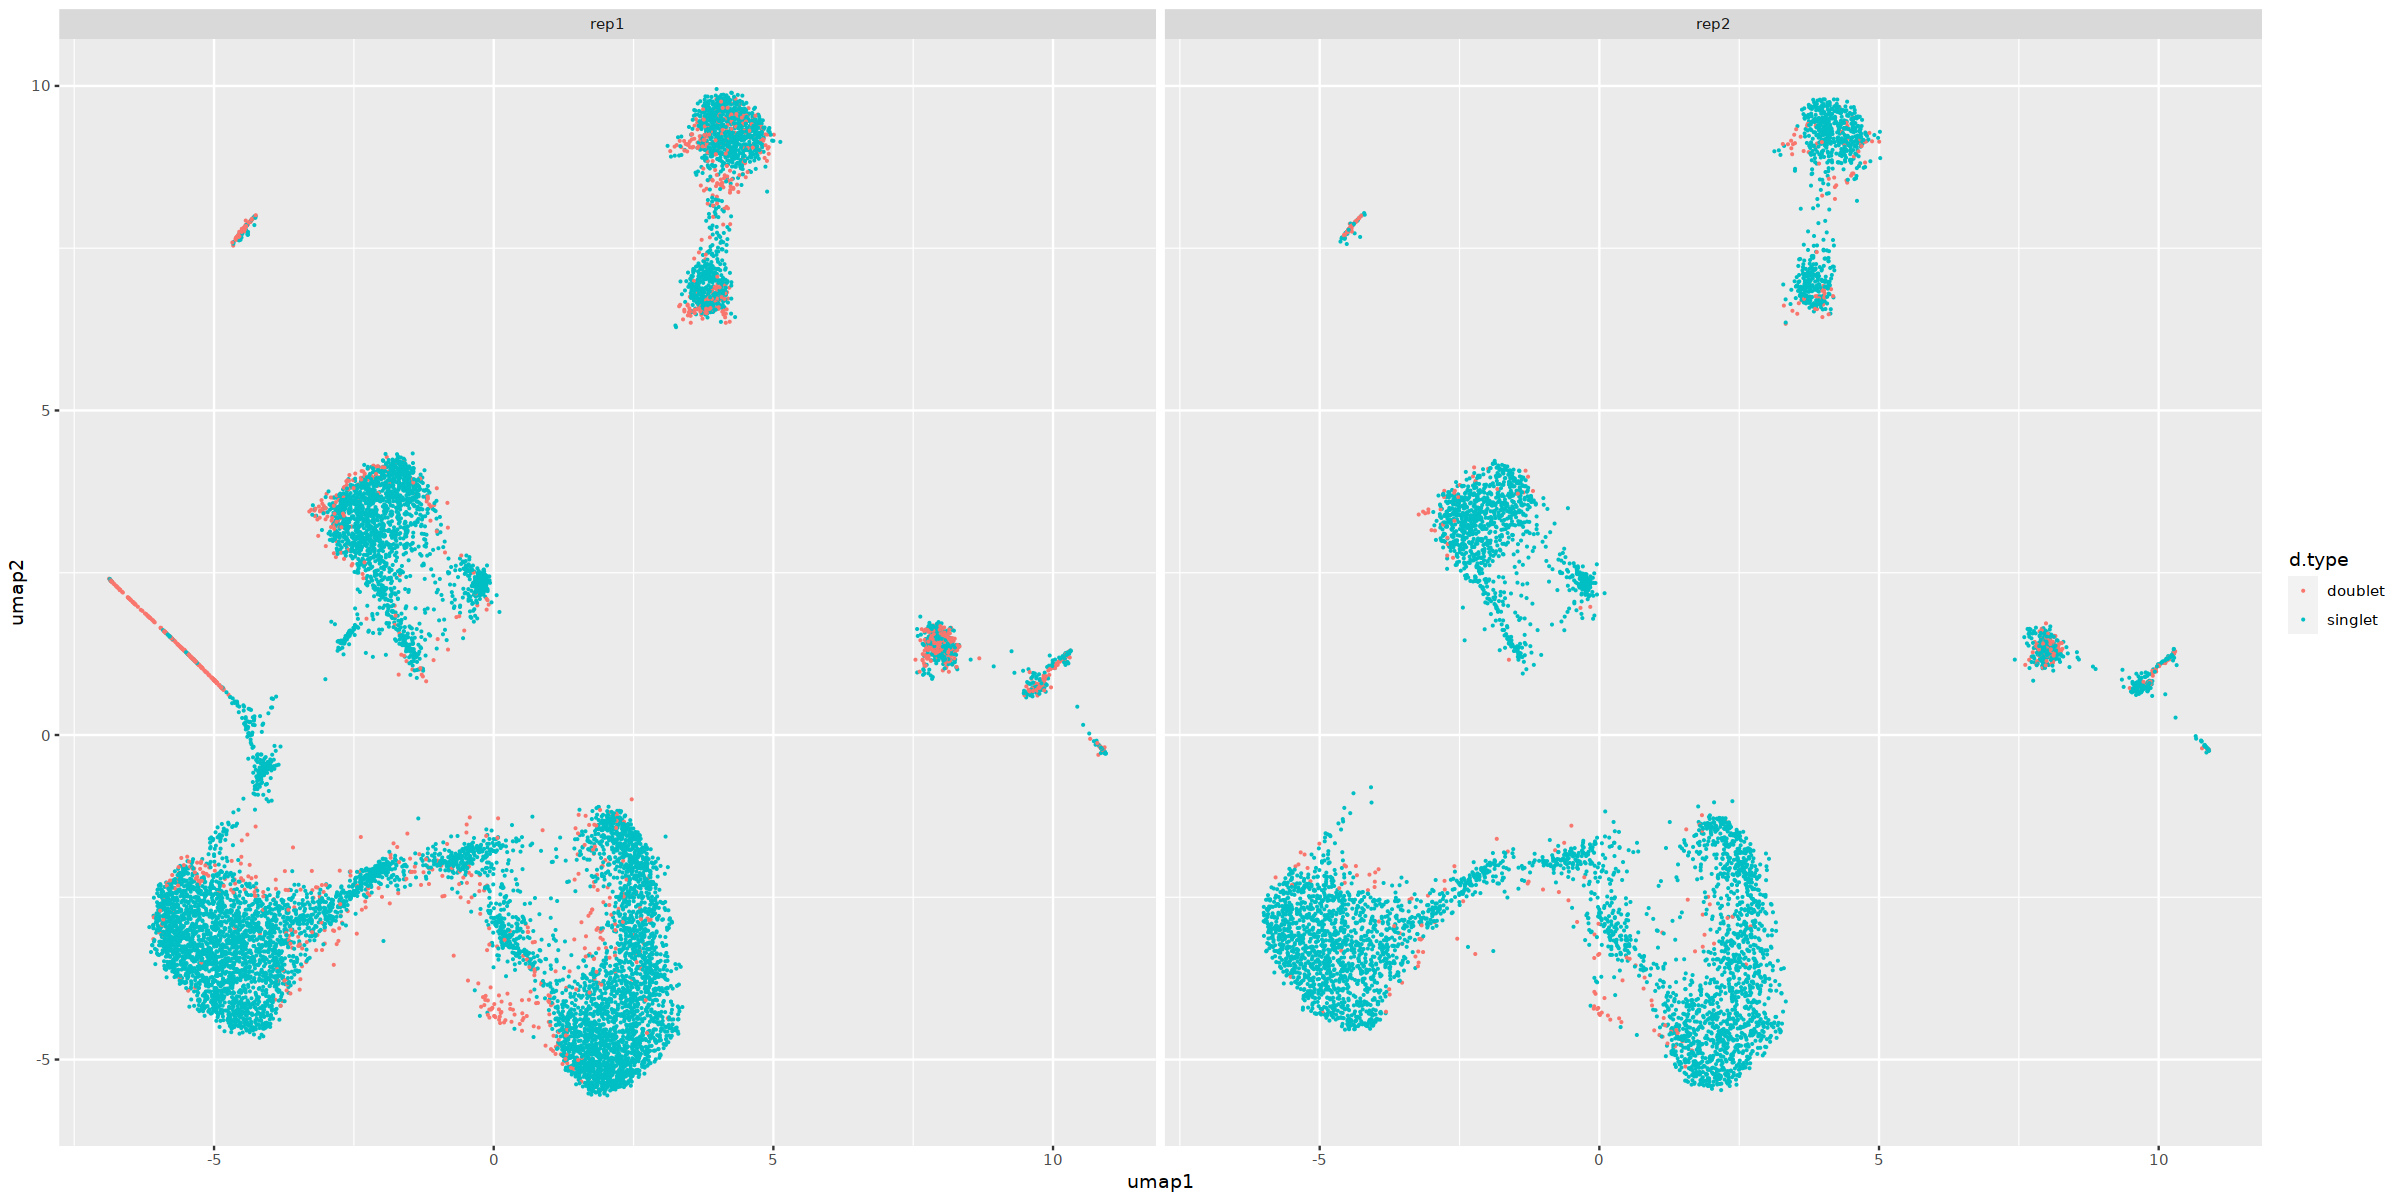

In [23]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(tfidf.obj.dob.filt.removed.graph ,aes(umap1, umap2, color = d.type)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

In [24]:
tfidf.obj.dob.filt.removed <- remove_top_x_doublet_percent(tfidf.obj.dob.filt)

   * Doublet filtering * Number cells removed= 929  Filtered: cells = 16624 | peaks = 70125



In [25]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt.removed, 
                        res=2,
                        verbose=T,
                        svd_slotName= "SVD",
                        cleanCluster=T)

tfidf.obj.dob.filt.clusters.cleaned <- filterSingle(tfidf.obj.dob.filt.clusters$Clusters, 
            k=20,threshold=3)

tfidf.obj.dob.filt.clusters$Clusters <- tfidf.obj.dob.filt.clusters.cleaned

 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16321
Number of edges: 1195810

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.7784
Number of communities: 22
Elapsed time: 42 seconds


 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 16202

 - filtering clusters with low cell/read counts ...



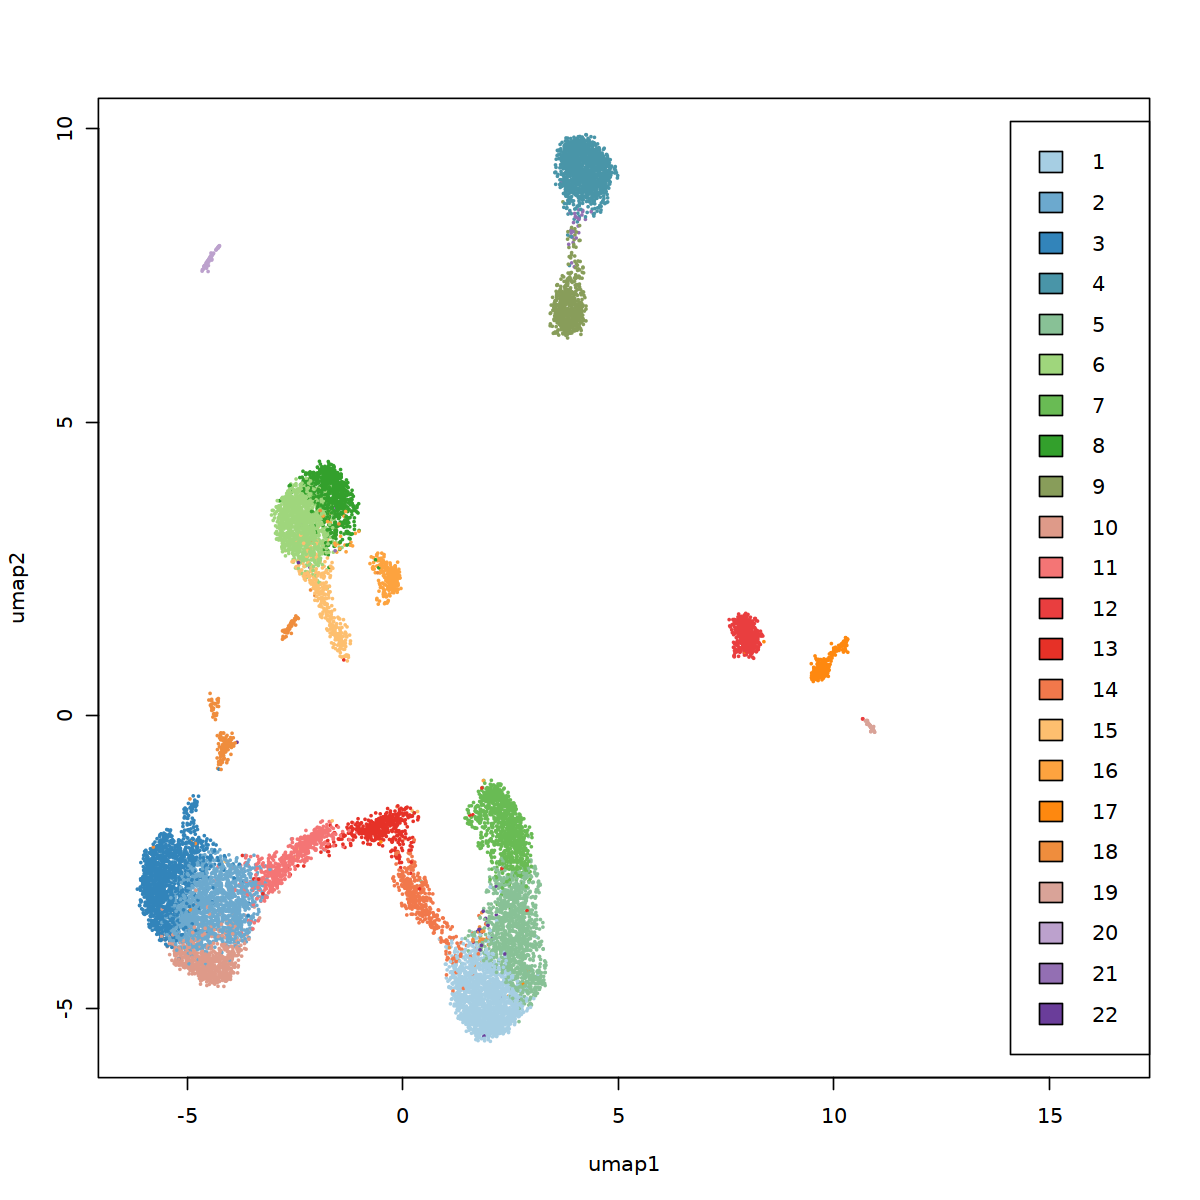

In [26]:
#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()

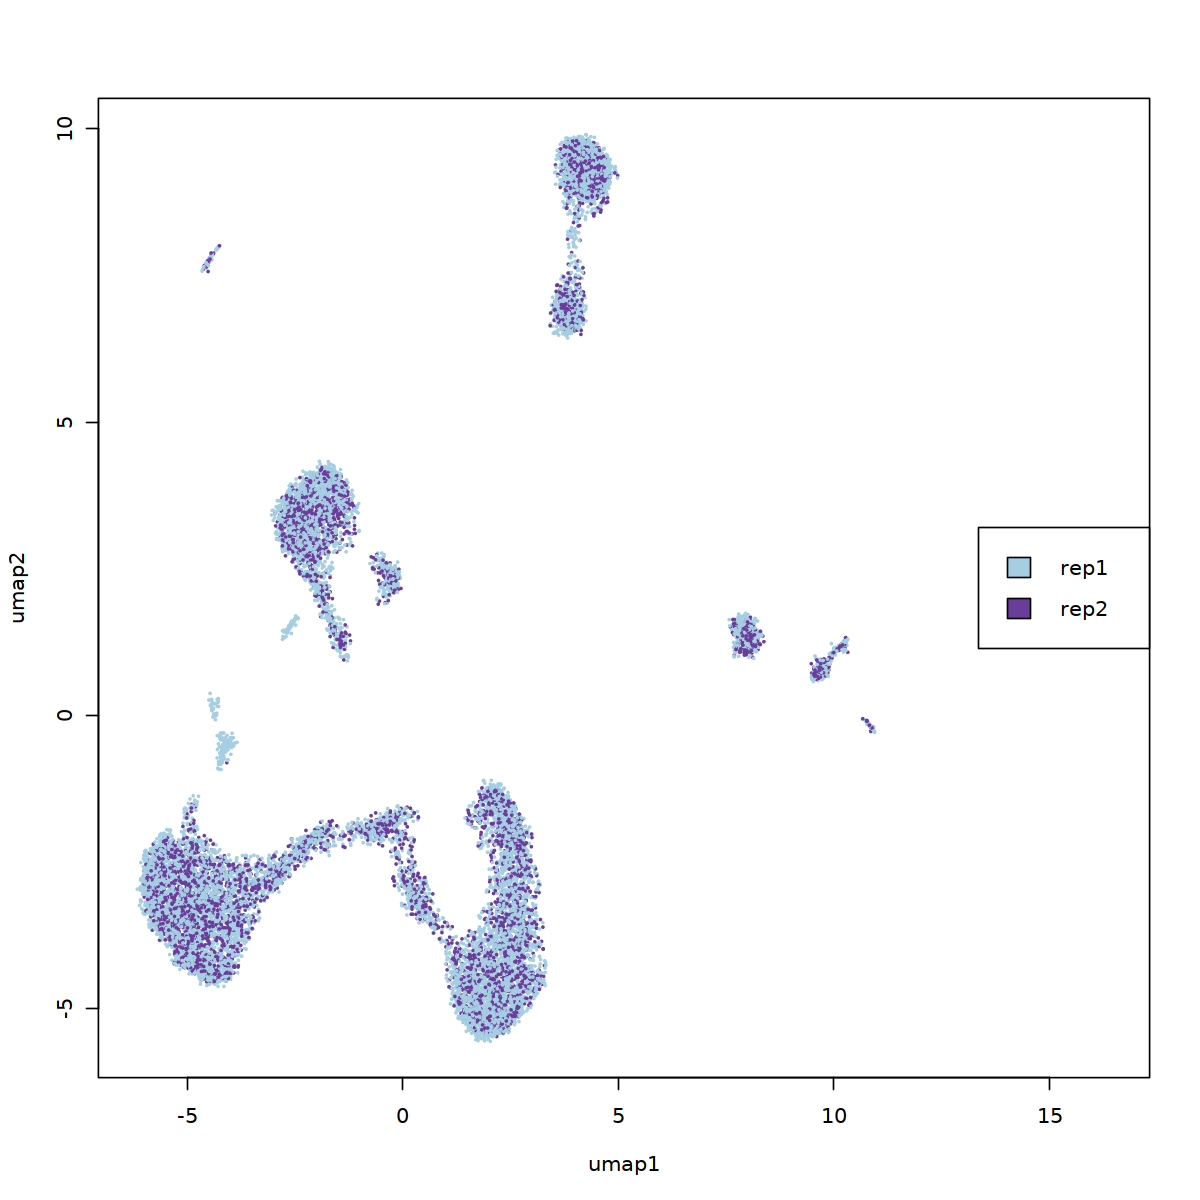

In [27]:
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

In [28]:
genotype_doublet_detection <- read_tsv("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/QC_output/Zm_Mo17B73_P2_G031_10x.rep1.doublet_genotypes.txt", col_names = TRUE)  %>% 
    filter(final_cell_assignment == "Doublet")
sum(genotype_doublet_detection$cellID %in% tfidf.obj.dob.filt.clusters$Clusters$cellID)
remove_vector <- as.vector(genotype_doublet_detection$cellID)

Rows: 744 Columns: 37

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (9): cellID, BARCODE, DROPLET.TYPE, BEST.GUESS, NEXT.GUESS, SNG.BEST.GU...
dbl (26): total.x, tss.x, acrs.x, nSites.x, log10nSites.x, umap1, umap2, Lou...
lgl  (2): ptmt.x, ptmt.y


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] 5

In [29]:
remove_cell_IDs <- function(obj, cell_ID_names_rm) { 

    old_meta <- obj$Clusters
    
    new_meta <- old_meta[!old_meta$cellID %in% cell_ID_names_rm, ] 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

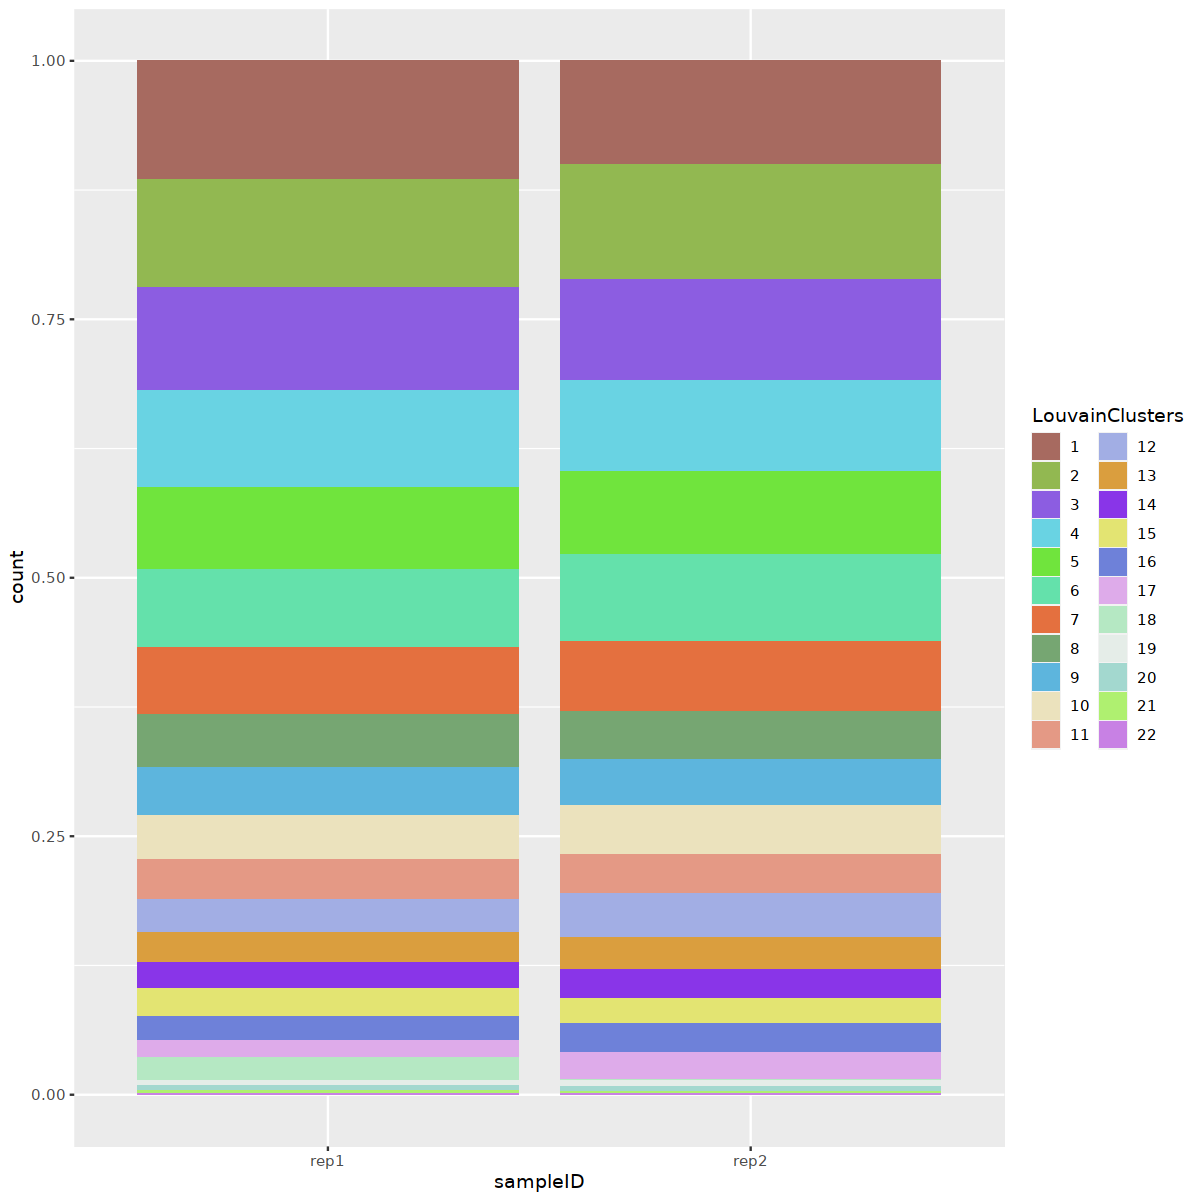

In [30]:
library(RColorBrewer)
other <- randomcoloR::distinctColorPalette(k = 41)
cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)
ggplot(cell_converted_trible,aes(x = sampleID, fill = LouvainClusters)) + 
    geom_bar(position = "fill") + scale_fill_manual(values=other)

In [31]:
final_removed_genotype_doublets <- remove_cell_IDs(tfidf.obj.dob.filt.clusters,remove_vector)

   * Doublet filtering * Number cells removed= 5  Filtered: cells = 15836 | peaks = 70124



In [32]:
str(cell_converted_trible)

tibble [15,841 × 13] (S3: tbl_df/tbl/data.frame)
 $ cellID         : chr [1:15841] "BC:Z:GTGAAAGATCAGAGCGAGTGGCCACTAA-Zm_rep1_P4_10x.rep1" "BC:Z:CGTACGCTTGTACTAAGGGTAGCAACAT-Zm_rep1_P7_10x.rep1" "BC:Z:GTTTCGCCGTCCAGCGAGTTTCGACTAA-Zm_rep1_P6_10x.rep1" "BC:Z:CGTACGAGTCAAAAACAGTGGCCACTAA-Zm_rep1_P7_10x.rep1" ...
 $ total          : num [1:15841] 130500 66736 55804 53708 51297 ...
 $ tss            : num [1:15841] 30598 27423 19968 17311 24619 ...
 $ acrs           : num [1:15841] 43932 46597 31883 26815 42278 ...
 $ ptmt           : num [1:15841] NA NA NA NA NA NA NA NA NA NA ...
 $ nSites         : num [1:15841] 72161 33010 29000 30014 24360 ...
 $ log10nSites    : num [1:15841] 4.86 4.52 4.46 4.48 4.39 ...
 $ sampleID       : chr [1:15841] "rep1" "rep1" "rep1" "rep1" ...
 $ umap1          : num [1:15841] -1.99 -1.27 -1.47 4.32 -1.18 ...
 $ umap2          : num [1:15841] 3.2 3.35 3.94 8.88 3.42 ...
 $ doubletscore   : num [1:15841] 0.388 0.435 0.424 0.671 0.212 ...
 $ d.type         : ch

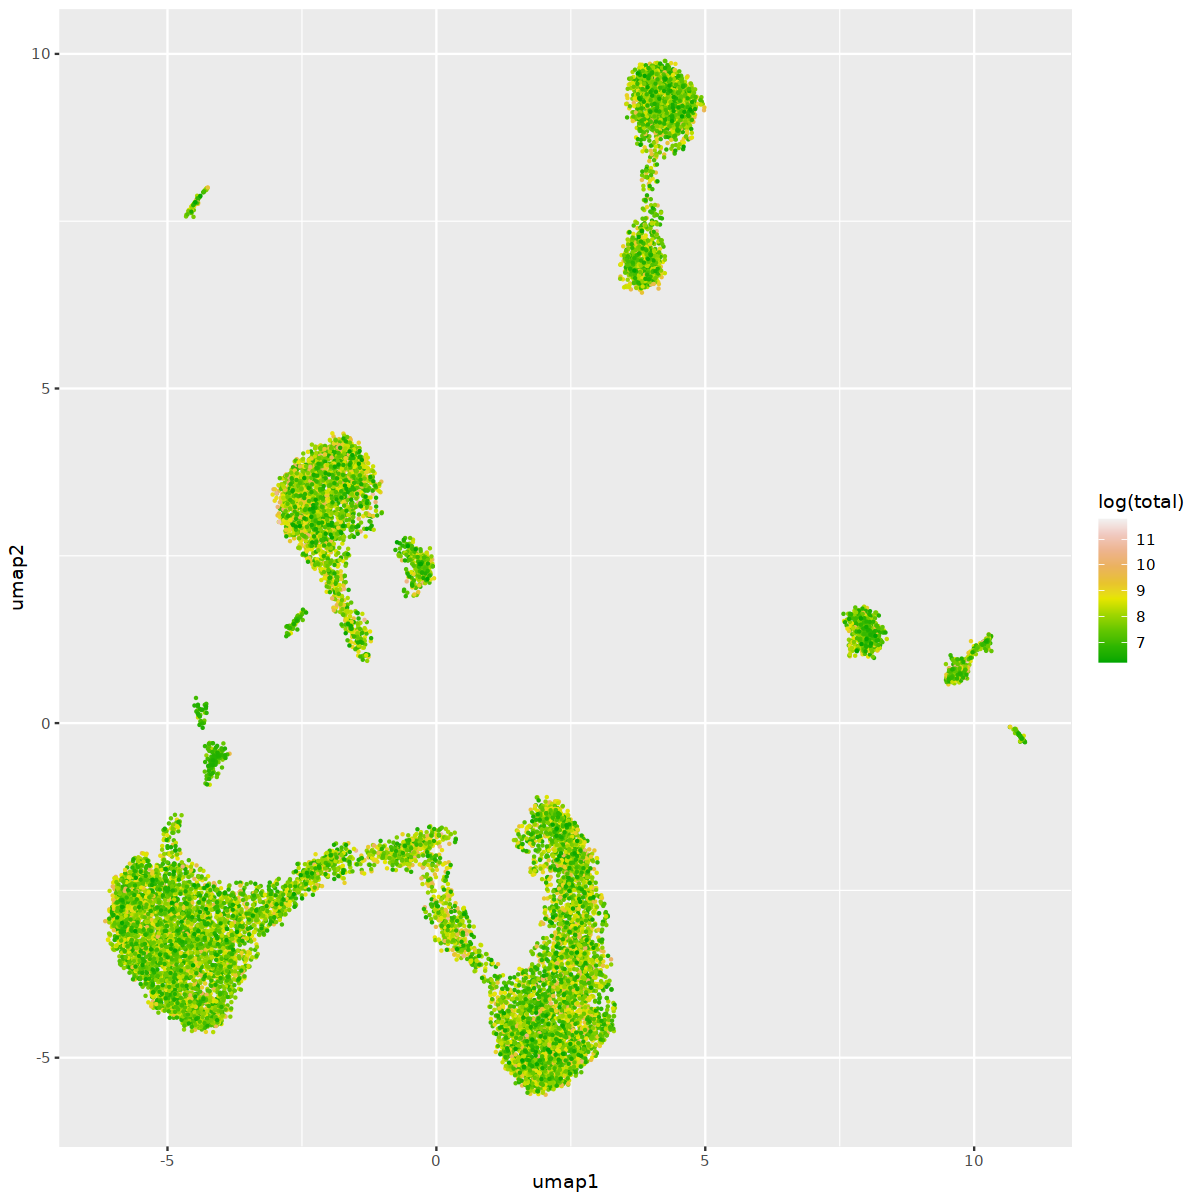

In [33]:
ggplot(cell_converted_trible ,aes(x = umap1, y=umap2, colour= log(total))) + 
    geom_point(size = .2) + scale_colour_gradientn(colours = terrain.colors(10))

In [34]:

prefix <- "Zm_leaf.merged_replicates.knn_100.stict_peak_filtering"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/clustering/"
paste0(data_path, prefix,".merged_clusters.sparse")
# output text files
nmf.meta <- final_removed_genotype_doublets$Clusters
nmf.rd <- final_removed_genotype_doublets$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")

[1] "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/QC_output/Zm_leaf.merged_replicates.knn_100.stict_peak_filtering.merged_clusters.sparse"

In [35]:
#Generate Sparse Matrix-
trip <- as.data.frame(summary(tfidf.obj.dob.filt.clusters$counts))
trip$i <- rownames(tfidf.obj.dob.filt.clusters$counts)[trip$i]
trip$j <- colnames(tfidf.obj.dob.filt.clusters$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

### Run same Analysis but with Modified SVD Parameters

In [53]:
library("here")
library(devtools)
library(Seurat)
library(Socrates)
library(harmony)
library(RcppML)


rep_1 <- here(data_path,"zea_mays.sciATAC_rep1_QC_soc_obj.rds")
rep_2 <- here(data_path,"zea_mays.sciATAC_rep2_QC_soc_obj.rds")
prefix <- "Zm_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj


print("Generating Graphs")
# estimate log10 number of accessible regions per cell
cell.counts <- Matrix::colSums(soc.obj$counts)

# estimate peak accessibility frequency across cells
site.freq <- Matrix::rowMeans(soc.obj$counts)


# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=cell.counts.threshold,  # minimum number of accessible features per cell
                     min.t=0.005,  # minimum feature frequency across cells
                     max.t=0.0001, # maximum feature frequency across cells
                     verbose=T)


# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)


# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="SVD", 
                      n.pcs=30, 
                      num.var=35000,
                      svd_slotName="SVD")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=100,
                       m.dist=0.05,
                       svd_slotName="SVD")


tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "SVD", svd_slotName="SVD")


tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=F, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

[1] "Merging Object"
[1] "Generating Socrates Obj"
[1] "Generating Graphs"


   * Input: cells = 17959 | peaks = 2934334

   * Filtered: cells = 17844 | peaks = 86582

 - non-linear dimensionality reduction with UMAP ...

14:48:59 UMAP embedding parameters a = 1.75 b = 0.8421

14:48:59 Read 17844 rows and found 29 numeric columns

14:48:59 Using Annoy for neighbor search, n_neighbors = 100

14:48:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:49:03 Writing NN index file to temp file /tmp/Rtmp8VXWjN/file8a9a6a98ca77

14:49:04 Searching Annoy index using 24 threads, search_k = 10000

14:49:06 Annoy recall = 100%

14:49:26 Commencing smooth kNN distance calibration using 24 threads

14:49:34 Initializing from normalized Laplacian + noise

14:49:38 Commencing optimization for 200 epochs, with 2683404 positive edges

14:50:42 Optimization fin

In [29]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
prcnt_to_remove

[1] 2.666365

In [30]:
prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
calculated_value <- (100 - prcnt_to_remove)/100
remove_val_greater <- sort(tfidf.obj.dob.filt$meta$doubletscore)[calculated_value*length(tfidf.obj.dob.filt$meta$doubletscore)]

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ readr::col_factor() masks Socrates::col_factor(), scales::col_factor()
✖ dplyr::collapse()   masks IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()      masks matrixStats::count()
✖ dplyr::desc()       masks IRanges::desc()
✖ purrr::discard()    masks Socrates::discard(), scales::discard()
✖ tidyr::expand()     masks Socrates::expand(), S4Vectors::expand(), Matrix::expand()
✖ tidyr::fill()       masks VGAM::fill()
✖ dpl

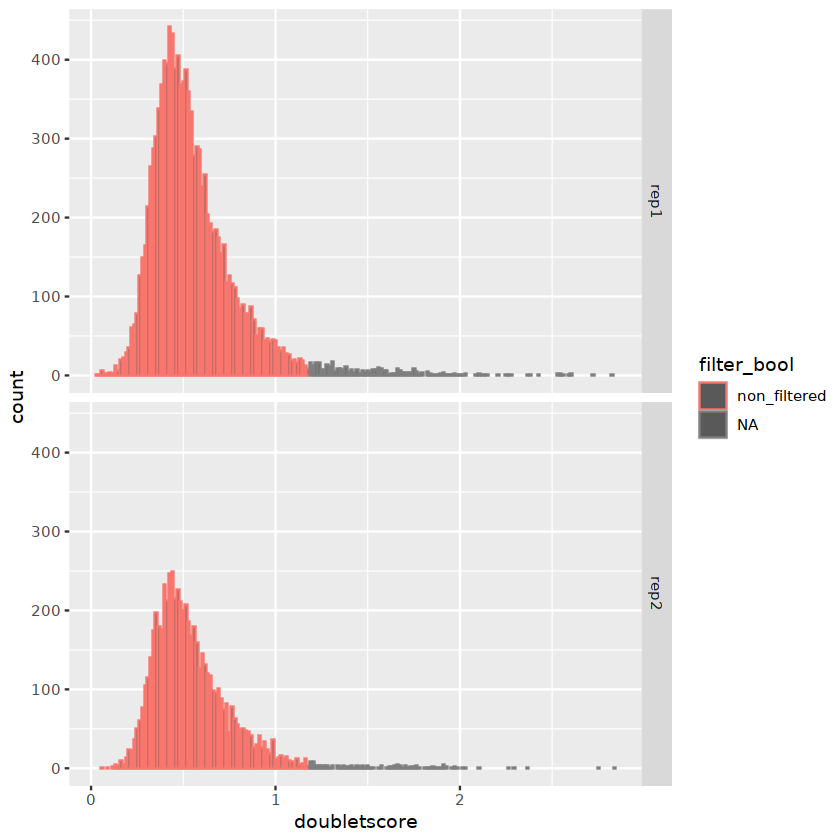

In [31]:
library(tidyverse)
as_tibble(tfidf.obj.dob.filt$meta) %>% 
    mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
             doubletscore < remove_val_greater ~ "filtered"))  %>% 
    ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)

In [28]:
remove_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered"))  %>% 
        ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)
    
    new_meta <- subset(old_meta, doubletscore < calculated_value) 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    new_meta$d.type <- "singlet"
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

plot_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered")) 

    
    return(grabbed_graph)

}

In [58]:
tfidf.obj.dob.filt.removed <- remove_top_x_doublet_percent(tfidf.obj.dob.filt)

   * Doublet filtering * Number cells removed= 1184  Filtered: cells = 16660 | peaks = 86582



In [59]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt.removed, 
                        res=2,
                        verbose=T,
                        svd_slotName= "SVD",
                        cleanCluster=T)

tfidf.obj.dob.filt.clusters.cleaned <- filterSingle(tfidf.obj.dob.filt.clusters$Clusters, 
            k=20,threshold=3)

tfidf.obj.dob.filt.clusters$Clusters <- tfidf.obj.dob.filt.clusters.cleaned

 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16439
Number of edges: 1522189

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.7759
Number of communities: 22
Elapsed time: 89 seconds


 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 16312

 - filtering clusters with low cell/read counts ...



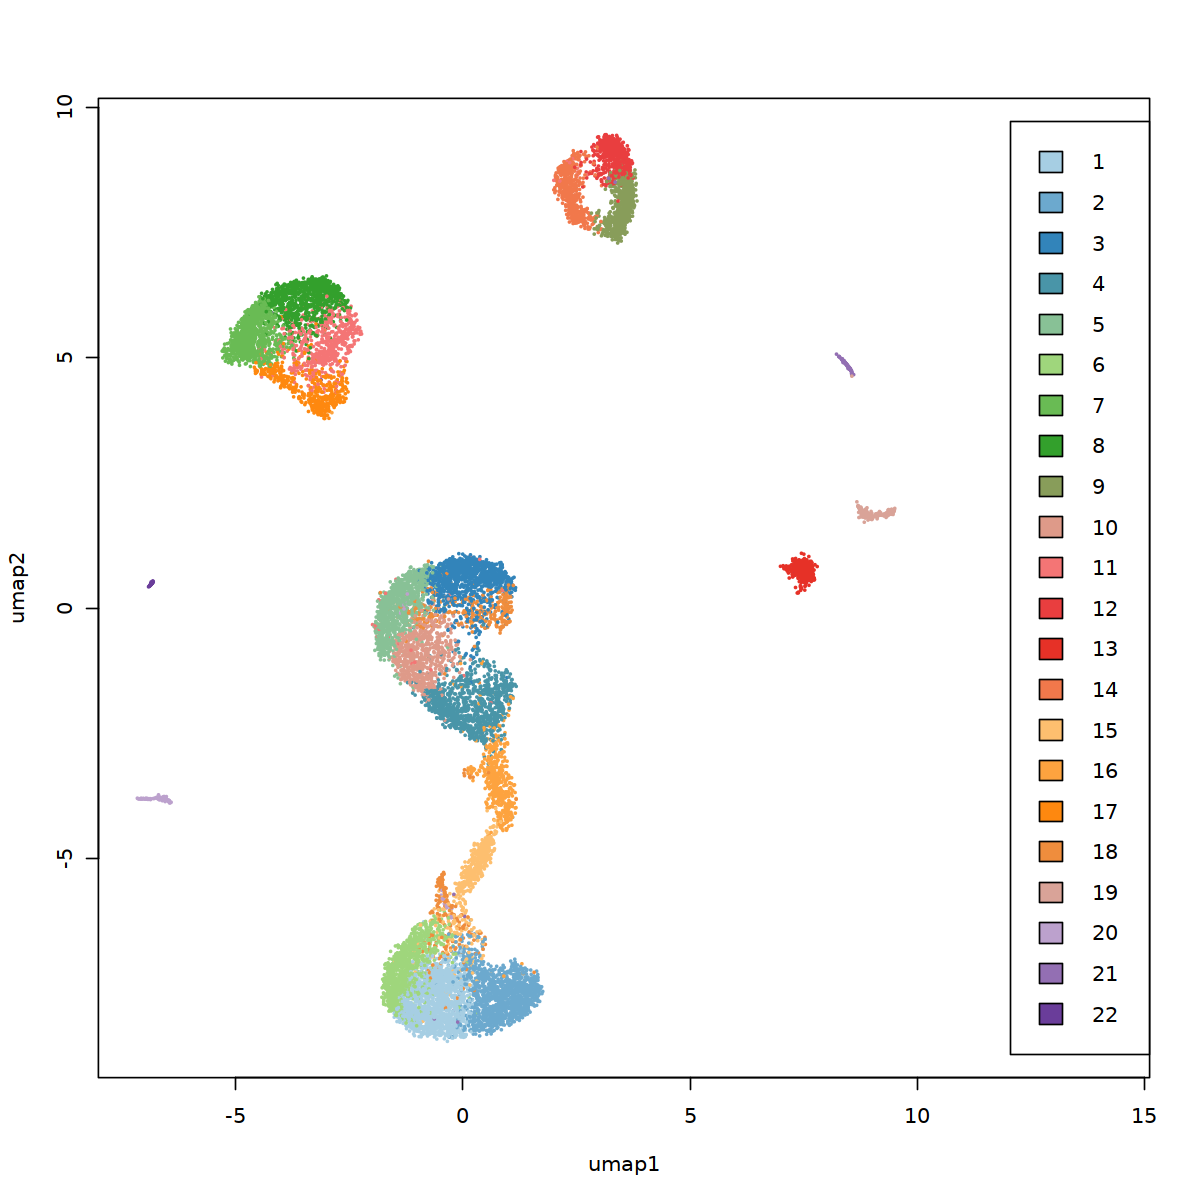

In [60]:
#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()




In [61]:
genotype_doublet_detection <- read_tsv("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/QC_output/Zm_Mo17B73_P2_G031_10x.rep1.doublet_genotypes.txt", col_names = TRUE)  %>% 
    filter(final_cell_assignment == "Doublet")
sum(genotype_doublet_detection$cellID %in% tfidf.obj.dob.filt.clusters$Clusters$cellID)
remove_vector <- as.vector(genotype_doublet_detection$cellID)

Rows: 744 Columns: 37

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (9): cellID, BARCODE, DROPLET.TYPE, BEST.GUESS, NEXT.GUESS, SNG.BEST.GU...
dbl (26): total.x, tss.x, acrs.x, nSites.x, log10nSites.x, umap1, umap2, Lou...
lgl  (2): ptmt.x, ptmt.y


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] 6

In [62]:
remove_cell_IDs <- function(obj, cell_ID_names_rm) { 

    old_meta <- obj$Clusters
    
    new_meta <- old_meta[!old_meta$cellID %in% cell_ID_names_rm, ] 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

   * Doublet filtering * Number cells removed= 6  Filtered: cells = 16092 | peaks = 86582



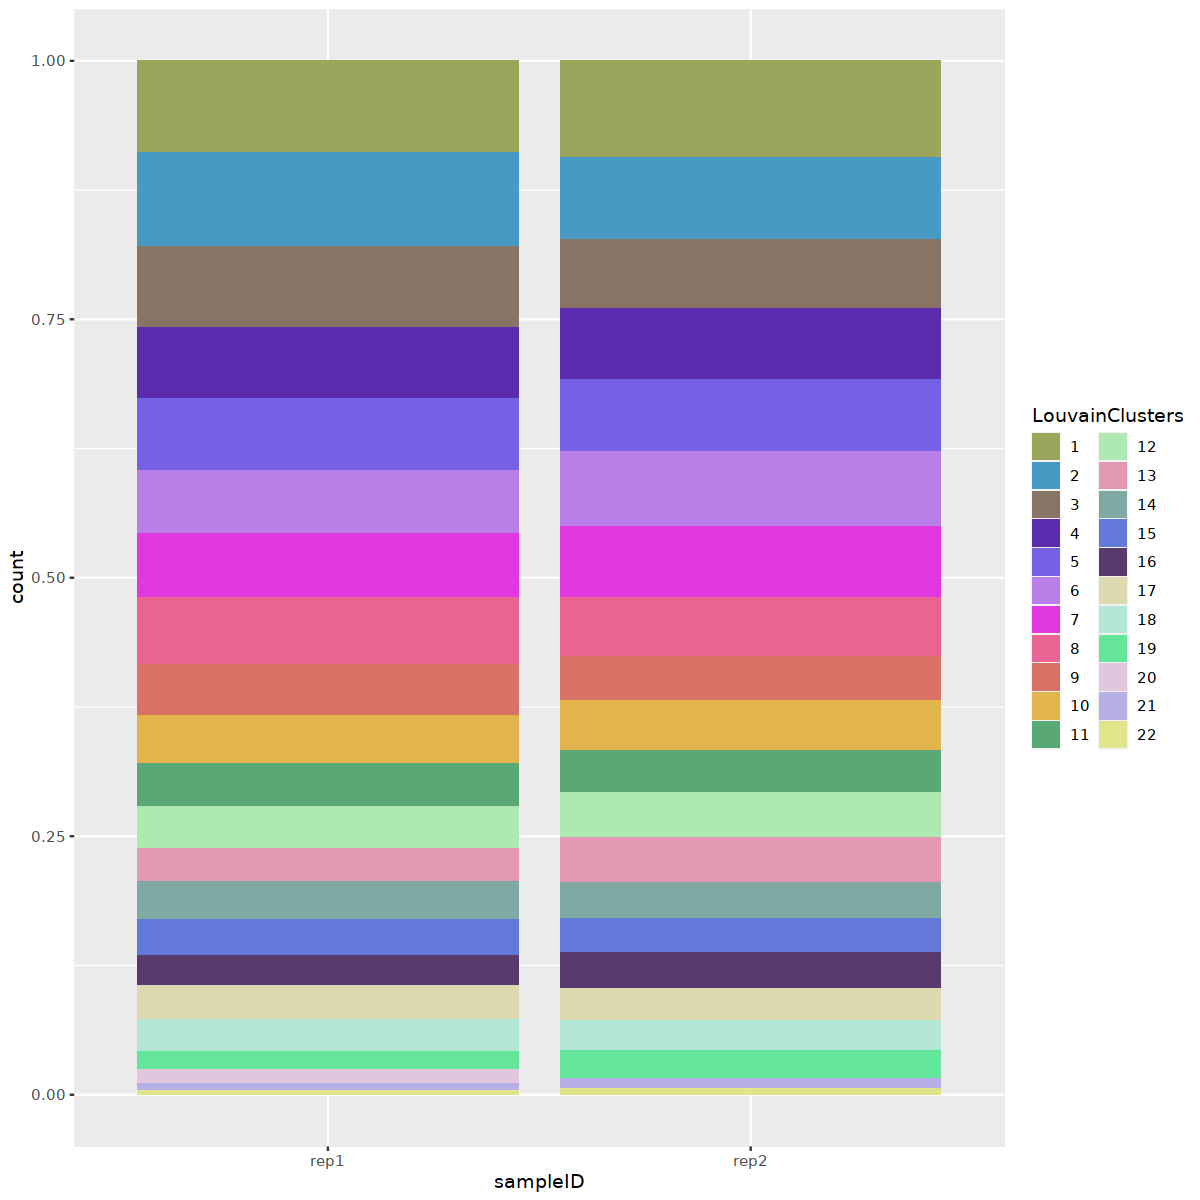

In [63]:
library(RColorBrewer)
library(tidyverse)
other <- randomcoloR::distinctColorPalette(k = 41)
cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)
ggplot(cell_converted_trible,aes(x = sampleID, fill = LouvainClusters)) + 
    geom_bar(position = "fill") + scale_fill_manual(values=other)

final_removed_genotype_doublets <- remove_cell_IDs(tfidf.obj.dob.filt.clusters,remove_vector)

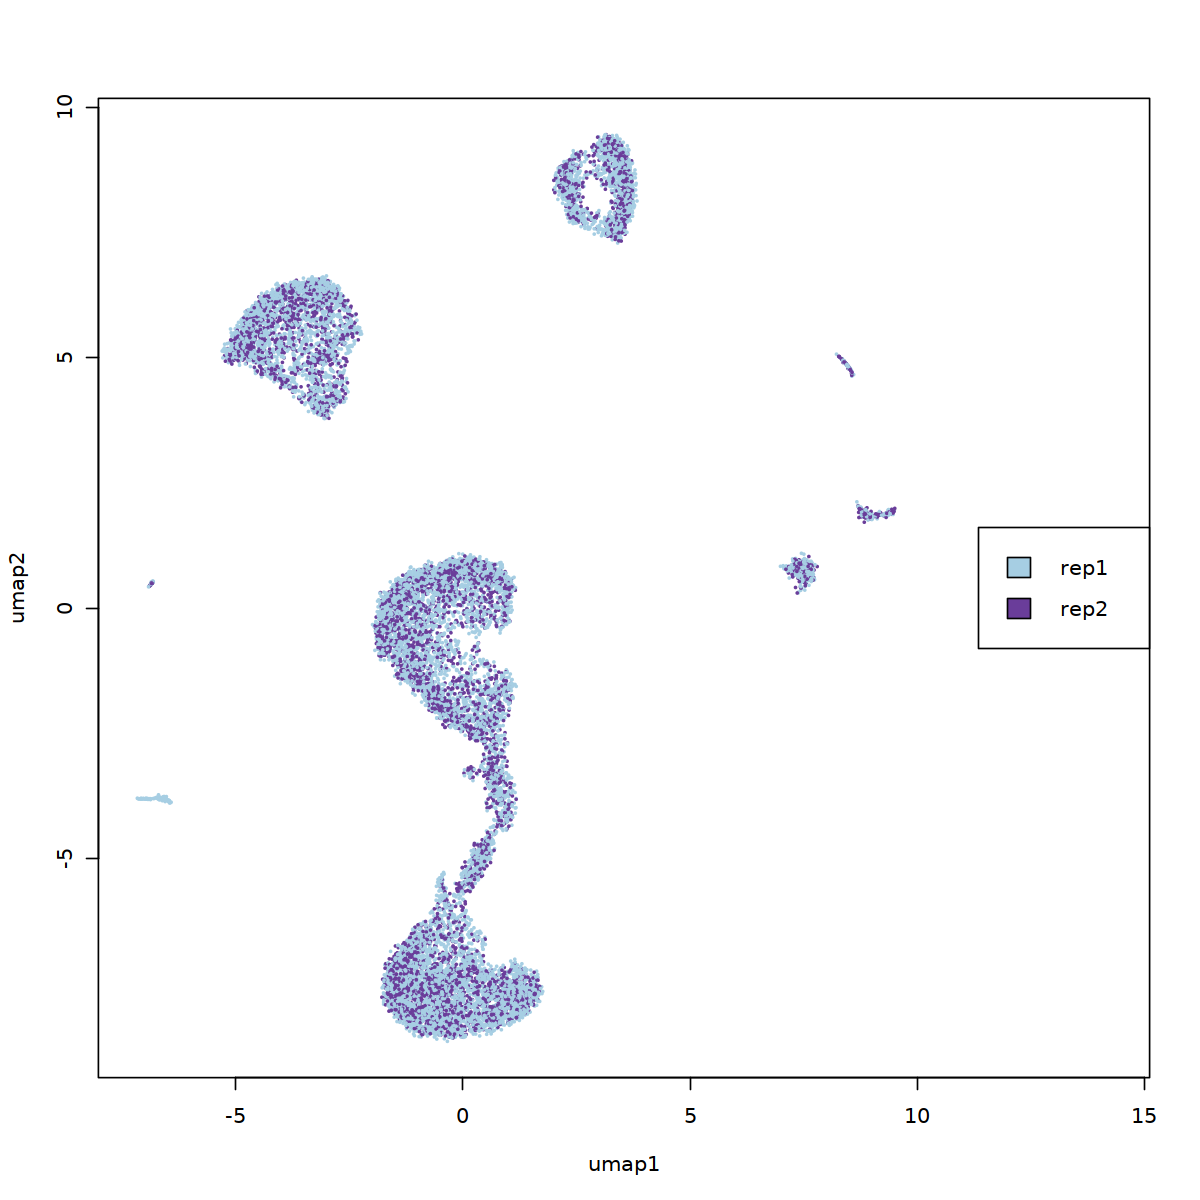

In [64]:
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

In [65]:

prefix <- "Zm_leaf.merged_replicates.knn_100"


In [66]:
#prefix <- "Sb_leaf.merged_replicates"

output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/clustering"
# output text files
nmf.meta <- tfidf.obj.dob.filt.clusters$Clusters
nmf.rd <- tfidf.obj.dob.filt.clusters$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")


In [67]:
#Generate Sparse Matrix-
trip <- as.data.frame(summary(tfidf.obj.dob.filt.clusters$counts))
trip$i <- rownames(tfidf.obj.dob.filt.clusters$counts)[trip$i]
trip$j <- colnames(tfidf.obj.dob.filt.clusters$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

In [68]:
saveRDS(tfidf.obj.dob.filt.clusters, file = paste0(output_location,prefix, ".SVD.full.rds"))

# Final Re-Run --- Same SVD Modified max cutoff for ACRs

[1] "Merging Object"
[1] "Generating Socrates Obj"
[1] "Generating Graphs"


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"3 x values <= 0 omitted from logarithmic plot"


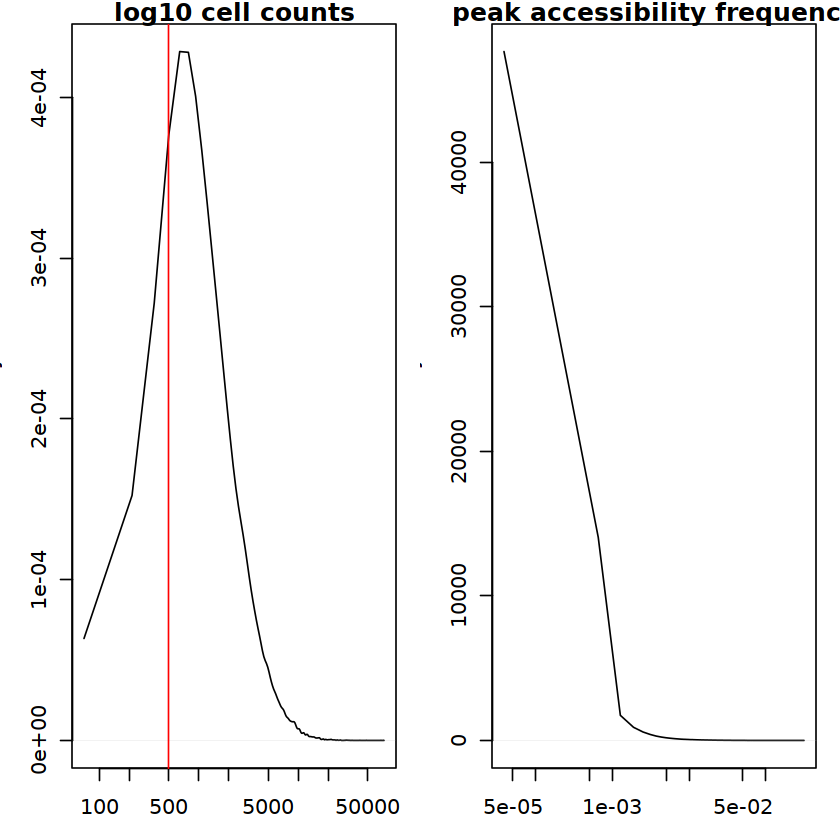

In [11]:
rep_1 <- here(data_path,"zea_mays.sciATAC_rep1_QC_soc_obj.rds")
rep_2 <- here(data_path,"zea_mays.sciATAC_rep2_QC_soc_obj.rds")
prefix <- "Zm_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj

print("Generating Graphs")
# estimate log10 number of accessible regions per cell
cell.counts <- Matrix::colSums(soc.obj$counts)

# estimate peak accessibility frequency across cells
site.freq <- Matrix::rowMeans(soc.obj$counts)

layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")


In [12]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=cell.counts.threshold,  # minimum number of accessible features per cell
                     min.t=0.001,  # minimum feature frequency across cells
                     max.t=0.2, # maximum feature frequency across cells
                     verbose=T)


# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)

   * Input: cells = 17959 | peaks = 2934334

   * Filtered: cells = 16821 | peaks = 206910



 - non-linear dimensionality reduction with UMAP ...

09:31:33 UMAP embedding parameters a = 1.577 b = 0.8951

09:31:33 Read 16821 rows and found 30 numeric columns

09:31:33 Using Annoy for neighbor search, n_neighbors = 100

09:31:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:31:34 Writing NN index file to temp file /tmp/RtmpA3VrgI/file1a6855eb68702

09:31:34 Searching Annoy index using 16 threads, search_k = 10000

09:31:36 Annoy recall = 99.95%

09:31:42 Commencing smooth kNN distance calibration using 16 threads

09:31:42 8 smooth knn distance failures

09:31:46 Initializing from normalized Laplacian + noise

09:31:47 Commencing optimization for 200 epochs, with 2538910 positive edges

09:32:18 Optimization finished



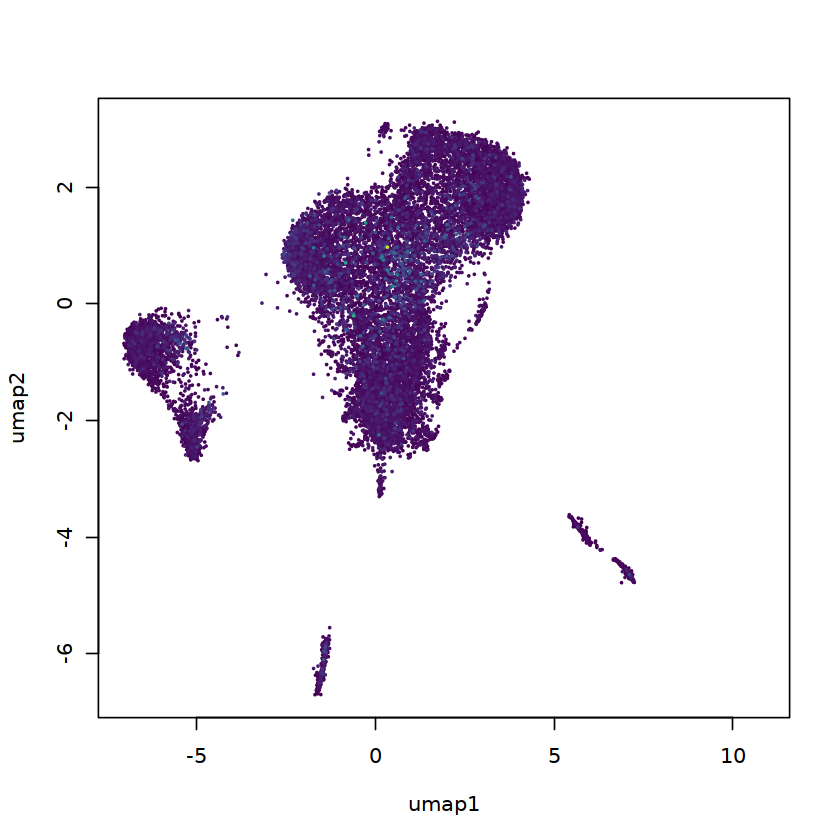

In [13]:
# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="SVD", 
                      n.pcs=30, 
                      num.var=35000,
                      svd_slotName="SVD")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=100,
                       m.dist=0.1,
                       svd_slotName="SVD")

plotUMAP(soc.obj.project_umap, cex=0.3, column = "total")

In [14]:
tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "SVD", svd_slotName="SVD")

 - Creating synthetic doublets ...

Warning message in mclapply(seq_len(nTrials), function(y) {:
"scheduled cores 2, 5, 10 did not deliver results, all values of the jobs will be affected"
 - Created 56000 synthetic doublets ...

 - Creating original projection ...

 - Merging synthetic and original cells ...

 - Projecting to UMAP ...



ERROR: Error in checkna(X): Missing values found in 'X'


In [ ]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=F, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
calculated_value <- (100 - prcnt_to_remove)/100
remove_val_greater <- sort(tfidf.obj.dob.filt$meta$doubletscore)[calculated_value*length(tfidf.obj.dob.filt$meta$doubletscore)]

In [ ]:
library(tidyverse)
as_tibble(tfidf.obj.dob.filt$meta) %>% 
    mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
             doubletscore < remove_val_greater ~ "filtered"))  %>% 
    ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)

In [ ]:
plotUMAP(tfidf.obj.dob.filt, cex=0.3, column = "d.type")

In [ ]:
remove_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered"))  %>% 
        ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)
    
    new_meta <- subset(old_meta, doubletscore < calculated_value) 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    new_meta$d.type <- "singlet"
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

plot_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered")) 

    
    return(grabbed_graph)

}

In [ ]:
tfidf.obj.dob.filt.removed.graph <- plot_top_x_doublet_percent(tfidf.obj.dob.filt)
head(tfidf.obj.dob.filt.removed.graph)

options(repr.plot.width=20, repr.plot.height=10)
ggplot(tfidf.obj.dob.filt.removed.graph ,aes(umap1, umap2, color = filter_bool)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

In [ ]:
tfidf.obj.dob.filt.removed <- remove_top_x_doublet_percent(tfidf.obj.dob.filt)

In [ ]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt.removed, 
                        res=2,
                        verbose=T,
                        svd_slotName= "SVD",
                        cleanCluster=T)

tfidf.obj.dob.filt.clusters.cleaned <- filterSingle(tfidf.obj.dob.filt.clusters$Clusters, 
            k=20,threshold=3)

tfidf.obj.dob.filt.clusters$Clusters <- tfidf.obj.dob.filt.clusters.cleaned

#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()

plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

In [ ]:
genotype_doublet_detection <- read_tsv("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/QC_output/Zm_Mo17B73_P2_G031_10x.rep1.doublet_genotypes.txt", col_names = TRUE)  %>% 
    filter(final_cell_assignment == "Doublet")
sum(genotype_doublet_detection$cellID %in% tfidf.obj.dob.filt.clusters$Clusters$cellID)
remove_vector <- as.vector(genotype_doublet_detection$cellID)

In [ ]:
remove_cell_IDs <- function(obj, cell_ID_names_rm) { 

    old_meta <- obj$Clusters
    
    new_meta <- old_meta[!old_meta$cellID %in% cell_ID_names_rm, ] 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

In [ ]:
library(RColorBrewer)
other <- randomcoloR::distinctColorPalette(k = 41)
cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)
ggplot(cell_converted_trible,aes(x = sampleID, fill = LouvainClusters)) + 
    geom_bar(position = "fill") + scale_fill_manual(values=other)

In [ ]:
final_removed_genotype_doublets <- remove_cell_IDs(tfidf.obj.dob.filt.clusters,remove_vector)
ggplot(cell_converted_trible ,aes(x = umap1, y=umap2, colour= log(total))) + 
    geom_point(size = .2) + scale_colour_gradientn(colours = terrain.colors(10))

In [ ]:

prefix <- "Zm_leaf.merged_replicates.knn_100.stict_peak_filtering.2"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/clustering/"
paste0(data_path, prefix,".merged_clusters.sparse")
# output text files
nmf.meta <- final_removed_genotype_doublets$Clusters
nmf.rd <- final_removed_genotype_doublets$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")

In [ ]:
#Generate Sparse Matrix-
trip <- as.data.frame(summary(tfidf.obj.dob.filt.clusters$counts))
trip$i <- rownames(tfidf.obj.dob.filt.clusters$counts)[trip$i]
trip$j <- colnames(tfidf.obj.dob.filt.clusters$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

## Try Clustering Again - Spending More time on ACR selection

[1] "Merging Object"
[1] "Generating Socrates Obj"
[1] "Generating Graphs"


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"3 x values <= 0 omitted from logarithmic plot"


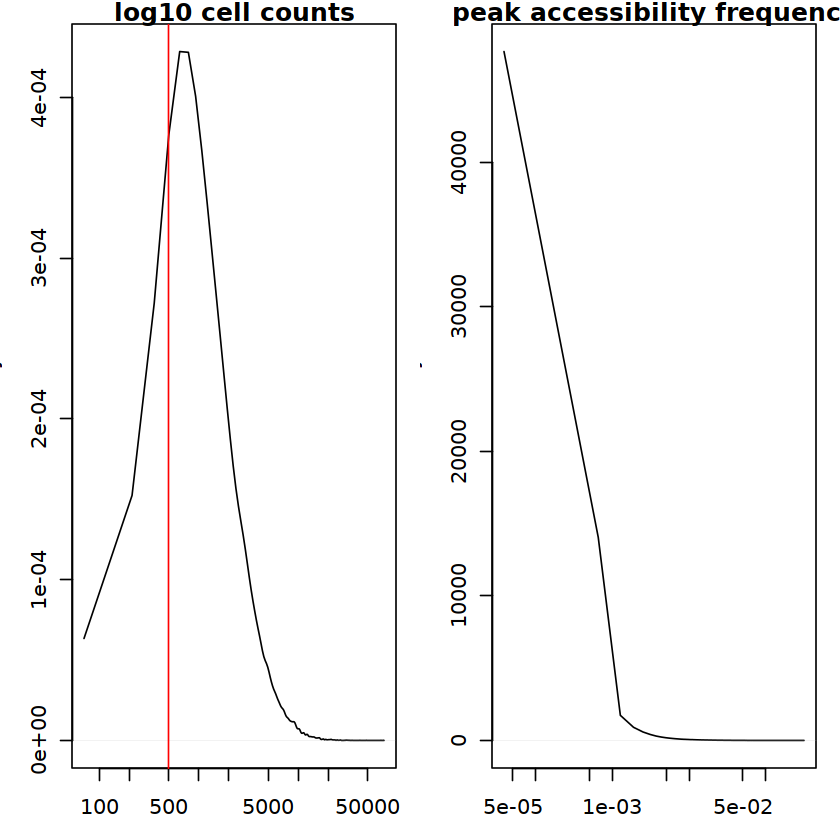

In [26]:
rep_1 <- here(data_path,"zea_mays.sciATAC_rep1_QC_soc_obj.rds")
rep_2 <- here(data_path,"zea_mays.sciATAC_rep2_QC_soc_obj.rds")
prefix <- "Zm_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj

print("Generating Graphs")
# estimate log10 number of accessible regions per cell
cell.counts <- Matrix::colSums(soc.obj$counts)

# estimate peak accessibility frequency across cells
site.freq <- Matrix::rowMeans(soc.obj$counts)

layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")


In [27]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=cell.counts.threshold,  # minimum number of accessible features per cell
                     min.t=0.005,  # minimum feature frequency across cells
                     max.t=0.05, # maximum feature frequency across cells
                     verbose=T)


# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)


# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="SVD", 
                      n.pcs=30, 
                      num.var=0,
                      svd_slotName="SVD")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=100,
                       m.dist=0.05,
                       svd_slotName="SVD")


tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "SVD", svd_slotName="SVD")


tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=F, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

   * Input: cells = 17959 | peaks = 2934334

   * Filtered: cells = 17809 | peaks = 82261

 - non-linear dimensionality reduction with UMAP ...

14:06:16 UMAP embedding parameters a = 1.75 b = 0.8421

14:06:16 Read 17809 rows and found 29 numeric columns

14:06:16 Using Annoy for neighbor search, n_neighbors = 100

14:06:16 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:06:19 Writing NN index file to temp file /tmp/RtmpWXzxQt/file2c6b1ae26fd3

14:06:19 Searching Annoy index using 16 threads, search_k = 10000

14:06:20 Annoy recall = 100%

14:06:25 Commencing smooth kNN distance calibration using 16 threads

14:06:29 Initializing from normalized Laplacian + noise

14:06:30 Commencing optimization for 200 epochs, with 2688986 positive edges

14:07:12 Optimization fin

In [32]:
tfidf.obj.dob.filt.removed <- remove_top_x_doublet_percent(tfidf.obj.dob.filt)

   * Doublet filtering * Number cells removed= 1027  Filtered: cells = 16782 | peaks = 82261



In [33]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt.removed, 
                        res=2,
                        verbose=T,
                        svd_slotName= "SVD",
                        cleanCluster=T)

tfidf.obj.dob.filt.clusters.cleaned <- filterSingle(tfidf.obj.dob.filt.clusters$Clusters, 
            k=20,threshold=3)

tfidf.obj.dob.filt.clusters$Clusters <- tfidf.obj.dob.filt.clusters.cleaned

 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16418
Number of edges: 1459757

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.7796
Number of communities: 22
Elapsed time: 49 seconds


1 singletons identified. 21 final clusters.

 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 16314

 - filtering clusters with low cell/read counts ...

